In [ ]:
# !pip install numpy
# !pip install matplotlib

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def readtxt(fname):
    f = open(fname, 'r')
    lines = f.readlines()
    content = []
    for line in lines:
        line = line.strip().split()  # 줄 끝의 줄 바꿈 문자를 제거한다.
        if len(line)==0:
            continue
        content.append(np.array(line,dtype=float))
    f.close()
    return np.array(content)

In [3]:
print("Read inlier data")
mat = readtxt("mag_array_inliers.txt")
matk=[]
for i in range(6):
    matk.append(mat[:,i*3:(i+1)*3])

Read inlier data


# $\bf{r_j}$ is a vector function of $K,b, \space and \space {x}_j$
## $\bf{r_j} = (K*\hat{x}_j + b) - m_j$

Inlier m_j


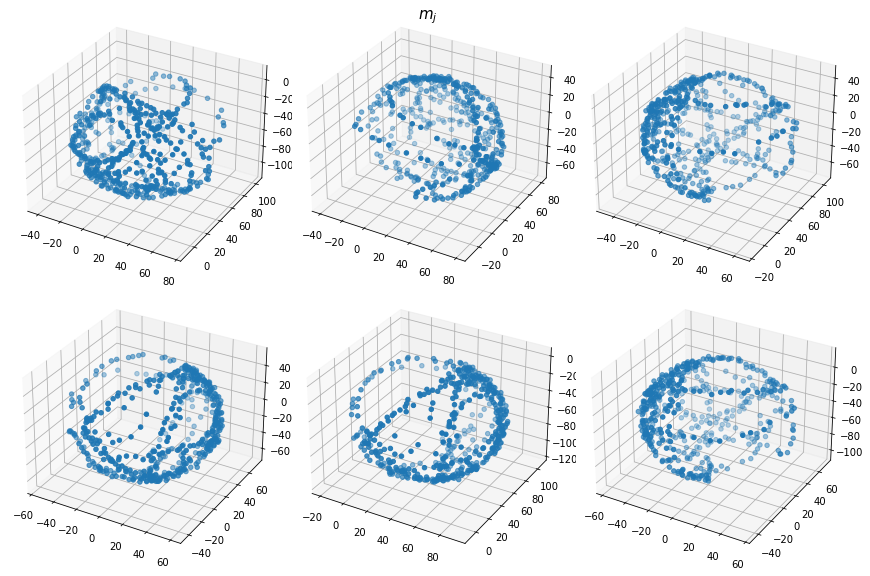

In [4]:
print("Inlier m_j")
fig = plt.figure(figsize=(12,8))
ax=[]
for i in range(6):
    ax.append(fig.add_subplot(int(f'23{i+1}'),projection='3d'))
    ax[i].scatter(matk[i][:,0],matk[i][:,1],matk[i][:,2])
fig.tight_layout()
fig.suptitle("$m_j$",fontsize=15,fontweight='bold')
plt.show()

In [5]:
# Normalize vector
def vec_normalize(x,n): # vector to vector (n*3,1) to (n*3,1)
    x_mat = x.reshape(n,3)
    x_hat = x_mat / (np.linalg.norm(x_mat,axis=1,keepdims=True)+1e-14)
    return x_hat.reshape(-1,1)

# Make diagnomal matrix for calculation
def mat_to_diag(K,n):
    K_diag = np.zeros((n*3,n*3))
    for i in range(n):
        K_diag[i*3:(i+1)*3,i*3:(i+1)*3] = K
    return K_diag

# Change vectorized parameter to K matrix, b, 
def param_to_kbx(p,n):
    K = p[:9].reshape(3,3).T
    b = p[9:12]
    x_vec = p[12:]
    return K, b, x_vec

def param_to_xhat(p,n):
    K, b, x_vec = param_to_kbx(p, n)
    x_hat = vec_normalize(x_vec,n)
    return x_hat.reshape(-1,3)
    
def param_to_est(p,n):
    K, b, x_vec = param_to_kbx(p, n)
    x_hat = vec_normalize(x_vec,n)
    K_diag = mat_to_diag(K,n)
    est = K_diag@x_hat+np.tile(b,[n,1])
    return est.reshape(-1,3)

# Draw reference circle
def draw_circle():
    u = np.linspace(0, 2 * np.pi, 100)
    v = np.linspace(0, np.pi, 100)

    x = 1 * np.outer(np.cos(u), np.sin(v))
    y = 1 * np.outer(np.sin(u), np.sin(v))
    z = 1 * np.outer(np.ones(np.size(u)), np.cos(v))
    return x, y, z

In [18]:
# Draw plots

# Plot x_hat & m_j
def draw_x_m_plots(ests,matk):
    fig = plt.figure(figsize=(15,10))
    ax=[]
    for i in range(6):
        ax.append(fig.add_subplot(int(f'23{i+1}'),projection='3d'))
        x,y,z = draw_circle()
        ax[i].plot_surface(x, y, z, rstride=4, cstride=4, color='b', linewidth=0, alpha=0.1)
        ax[i].scatter(ests[i][:,0],ests[i][:,1],ests[i][:,2],c='r')
    # fig.tight_layout()
    fig.suptitle("$\hat{X}$",fontsize=17,fontweight='bold')
        
    fig2 = plt.figure(figsize=(15,10))
    ax2=[]
    for i in range(6):
        ax2.append(fig2.add_subplot(int(f'23{i+1}'),projection='3d'))
        ax2[i].scatter(matk[i][:,0],matk[i][:,1],matk[i][:,2],label='m_j')
    # fig2.tight_layout()
    fig2.suptitle("$m_j$",fontsize=17,fontweight='bold')

# Plot K@x_hat+b & m_j on same plot
def draw_est_m_plots(ests,matk):
    fig = plt.figure(figsize=(15,10))
    ax=[]
    for i in range(6):
        ax.append(fig.add_subplot(int(f'23{i+1}'),projection='3d'))
        x,y,z = draw_circle()
        ax[i].plot_surface(x, y, z, rstride=4, cstride=4, color='b', linewidth=0, alpha=0.1)
        ax[i].scatter(ests[i][:,0],ests[i][:,1],ests[i][:,2],c='r',label='$K@\hat{x}+b$')
        ax[i].scatter(matk[i][:,0],matk[i][:,1],matk[i][:,2],label='m_j')
        ax[i].legend()
    # fig.tight_layout()
    fig.suptitle("Estiamte comparison",fontsize=15,fontweight='bold')

In [7]:
# Set initial parameters
def set_param(matk,k,init_type=0):
    n = matk[k].shape[0]
    K = np.eye(3)
    vec_K = K.T.reshape(-1,1)

    b = np.ones((3,1))

    # Different Initialization for X
    if init_type==0:
        X = matk[k].copy()
        X = X.reshape(n*3,1)
    elif init_type==1:
        X = matk[k].copy()+np.random.randn(n,3)*(2*np.random.randint(2)-1) # (489*3,1)
        X = X.reshape(n*3,1)
    elif init_type==2:
        X = np.random.randn(n,3)*50
        X = X.reshape(n*3,1)
    else :
        X = np.zeros((n*3,1))
        for i in range(n):
            x_j = np.mean(matk[k],axis=0)[i] + 50*np.random.rand(3)*(2*np.random.randint(2)-1)
            X[i*3:(i+1)*3] = x_j.reshape(-1,1)
    print(X.shape)
    return vec_K,b,X

In [8]:
# Compute residual
def compute_resi(p,m,n):
    # change m (489,3) to (489*3,1)
    m_vec = m.reshape(-1,1)

    K,b,x_vec = param_to_kbx(p,n)

    x_hat = vec_normalize(x_vec,n)
    K_diag = mat_to_diag(K,n)
    r = K_diag@x_hat+np.tile(b,[n,1])-m_vec

    return r

# Compute jacobian matrix
def compute_jacob(p,m,n):
    K,b,x = param_to_kbx(p,n)
    x_hat = vec_normalize(x,n).reshape(n,3)
    x_mat = x.reshape(n,3)

    J_k = np.empty((n*3,3*3))
    for i in range(n):
        x1,x2,x3 = x_hat[i]
        J_k[i*3:(i+1)*3,:3]= np.diag(np.repeat(x1,3))
        J_k[i*3:(i+1)*3,3:6]= np.diag(np.repeat(x2,3))
        J_k[i*3:(i+1)*3,6:]= np.diag(np.repeat(x3,3))
    
    J_b = np.tile(np.eye(3),[n,1])
    J_X = np.zeros((n*3,n*3))
    for i in range(n):
        norm_x = np.linalg.norm(x_mat[i])
        x_i = x_mat[i].reshape(3,1)
        J_xi = K@(np.eye(3)/norm_x - x_i@x_i.T/(norm_x**3))
        J_X[3*i:3*(i+1),3*i:3*(i+1)] = J_xi

    return np.concatenate((J_k, J_b, J_X),axis=1)

# Compute model quality
def compute_model_q(grad,dterm,r,r_new,dp):
    f_del = r_new.T@r_new - r.T@r
    q_del = grad.T@dp+1/2*dp.T@dterm@dp
    print("quality",f_del.item()/q_del.item())
    return f_del.item()/q_del.item()

In [9]:
# Calculate parameters & Adjust damping factor rambda for each Levenberg Marquardt iteration
def LM_iter(p,m,not_converged,damping,eta,tol_fac,cost):
    n=m.shape[0]
    J = compute_jacob(p,m,n) # Jacobian
    r = compute_resi(p,m,n) # vec
    grad = J.T@r
    hess = J.T@J
    damping_term = hess+damping*np.eye(hess.shape[0])
    dp = -np.linalg.inv(damping_term)@grad

    # K upper triangle
    dp[1]=0
    dp[2]=0
    dp[5]=0

    p_new = p+dp
    r_new = compute_resi(p_new,m,n)
    rho = compute_model_q(grad,damping_term,r,r_new,dp)

    # Update criterion
    if rho > eta:
        # print("updated")
        p = p_new.copy()
        new_cost = (np.sqrt(r_new.T@r_new)/n).item()
        prev_cost = (np.sqrt(r.T@r)/n).item()
        func_toler = np.abs(new_cost - prev_cost)
        not_converged = not(func_toler < tol_fac)
        cost.append(new_cost)
        print("func toler",func_toler)
        print("damping",damping)
        
    # Truth region size criteria
    if rho < 0.25:
        damping = min(4*damping,1e+14)
    elif rho > 0.75:
        damping = max(damping/2,1e-14)

    return p, damping, not_converged

In [10]:
def LM(matk,k):
    # Parametr Initialization
    vec_K, b, X = set_param(matk,k,0)
    m = matk[k].copy() #(489,3)
    n = m.shape[0]
    p0 = np.concatenate((vec_K,b,X),axis=0) # ((9,1),(3,1),(489*3,1))
    
    p = p0.copy()

    damping = 0.1
    tol_fac = 1e-3
    eta = 0
    not_converged = True
    cost=[]
    
    c=0
    while not_converged:
        p,damping,not_converged = LM_iter(p, m, not_converged, damping, eta, tol_fac, cost)
        if c>1000:
            print("Break because process doesn't end")
            break
        c+=1

    return p, cost # p 나중에 없애도 될듯

In [11]:
print("Optimize data of inliers 'matk'")
params=[]
costs_in = []
for i in range(6):
    p,cost = LM(matk,i)
    params.append(p)
    costs_in.append(cost)

Optimize data of inliers 'matk'
(1467, 1)
quality 1.9583153141606016
func toler 1.2292575510381738
damping 0.1
quality 2.2231457244950987
func toler 0.6121979194306646
damping 0.05
quality 2.5422090044019736
func toler 1.4226640601022047
damping 0.025
quality 3.505216866414363
func toler 6.897721002204124
damping 0.0125
quality 1.7760110673593061
func toler 7.104403733412568
damping 0.00625
quality 4.672620529926528
func toler 11.18519746046869
damping 0.003125
quality 1.9569807557235275
func toler 7.493240745642397
damping 0.0015625
quality 6.089842339647298
func toler 16.497707402628453
damping 0.00078125
quality -2.1339006302347343
quality 1.3542946085550491
func toler 4.612740757159628
damping 0.0015625
quality 1.877073582261785
func toler 4.505066439174799
damping 0.00078125
quality 2.011998450831944
func toler 6.829941825751652
damping 0.000390625
quality -8.859210587628471
quality 1.9840605974109866
func toler 5.201689601707276
damping 0.00078125
quality -10.167247781859183
qual

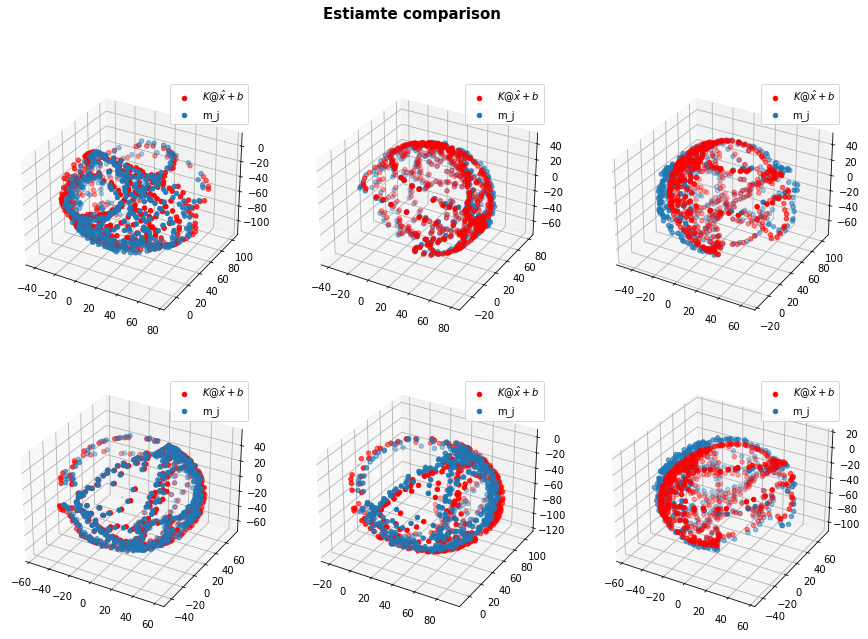

ValueError: 
$f{\hat{X}}$
^
Expected end of text, found '$'  (at char 0), (line:1, col:1)

<Figure size 1080x720 with 6 Axes>

ValueError: 
$f{m_j}$
^
Expected end of text, found '$'  (at char 0), (line:1, col:1)

<Figure size 1080x720 with 6 Axes>

In [19]:
n = matk[0].shape[0]
ests_in = [param_to_est(p,n) for p in params]
draw_est_m_plots(ests_in,matk)

xhats_in = [param_to_xhat(p,n) for p in params]
draw_x_m_plots(xhats_in,matk)

In [ ]:
fig, axes = plt.subplots(2,3,figsize=(15,7))
for i in range(6):
    axes[i//3,i%3].plot(range(len(costs_in[i])),costs_in[i])
fig.suptitle("Cost",fontsize=15,fontweight='bold')

# Robust optimization
## on data including outliers

In [ ]:
mat_out = readtxt("mag_array_outliers.txt")
mat_outk=[]
for i in range(6):
    mat_outk.append(mat_out[:,i*3:(i+1)*3])

In [ ]:
print("Comparison of Outlier included data and Outlier excluded data")
fig = plt.figure(figsize=(15,8))
ax=[]
for i in range(6):
    ax.append(fig.add_subplot(int(f'23{i+1}'),projection='3d'))
    ax[i].scatter(mat_outk[i][:,0],mat_outk[i][:,1],mat_outk[i][:,2],c='r',label = "outliers")
    ax[i].scatter(matk[i][:,0],matk[i][:,1],matk[i][:,2],c='g',label = "inliers")
    ax[i].legend()
fig.tight_layout()

### RANSAC robust optimization

In [ ]:
def ransac_sample(p,m,damping):
    thre = 10
    ransac_score=10
    for k in range(10):
        n=m.shape[0]
        J = compute_jacob(p,m,n) # Jacobian
        r = compute_resi(p,m,n) # vec
        
        sample_ind = np.random.permutation(n)[:300]
        J = J[sample_ind]
        r = r[sample_ind]
        
        grad = J.T@r
        hess = J.T@J
        damping_term = hess+damping*np.eye(hess.shape[0])
        dp = -np.linalg.inv(damping_term)@grad

        # K upper triangle
        dp[1]=0
        dp[2]=0
        dp[5]=0
        
        p_new = p+dp
        r_new = compute_resi(p_new,m,n)
        
        new_cost = (np.sqrt(r_new.T@r_new)/n).item()
        if new_cost<=thre:
           if ransac_score > new_cost:
               ransac_score = new_cost
               print("score",ransac_score)
               values = [grad,damping_term,r,r_new,dp]
    return values

In [ ]:
def ransac_iter(p,m,not_converged,damping,eta,tol_fac,cost):
    grad,damping_term,r,r_new,dp = ransac_sample(p,m,damping)
    
    rho = compute_model_q(grad,damping_term,r,r_new,dp)
    n=m.shape[0]
    # Update criterion
    if rho > eta:
        print("update")
        p = p+dp # p_new update
        new_cost = (np.sqrt(r_new.T@r_new)/n).item()
        prev_cost = (np.sqrt(r.T@r)/n).item()
        func_toler = np.abs(new_cost - prev_cost)
        not_converged = not(func_toler < tol_fac)
        cost.append(new_cost)
        print("func toler",func_toler)
        print("damping",damping)
        
    # Truth region size criteria
    if rho < 0.25:
        damping = min(4*damping,1e+14)
    elif rho > 0.75:
        damping = max(damping/2,1e-14)

    return p, damping, not_converged

In [ ]:
# ransac
def RANSAC(matk,k):
    vec_K, b, X = set_param(matk,k)
    # print(vec_K.shape)
    # print(b.shape)
    # print(X.shape)

    m = matk[k] #(489,3)
    n = m.shape[0]
    p0 = np.concatenate((vec_K,b,X),axis=0) # ((9,1),(3,1),(489*3,1))
    # print("p0",p0.shape)
    p = p0.copy()

    damping = 0.1
    tol_fac = 1e-3
    eta = 0
    not_converged = True
    cost=[]
    
    c=0
    while not_converged:
        n = 100
        p,damping,not_converged = ransac_iter(p, m, not_converged, damping, eta, tol_fac, cost)
        if c>100:
            print("break")
            break
        c+=1
    
    K, b, x_vec = param_to_kbx(p, n)
    x_hat = vec_normalize(x_vec,n)
    K_diag = mat_to_diag(K,n)
    est = K_diag@x_hat+np.tile(b,[n,1])

    return est.reshape(n,3), p, cost # p 나중에 없애도 될듯

In [ ]:
print("Optimized Outliers with ransac")
params_out_ran=[]
ests_out_ran = []
costs_out_ran = []
for i in range(6):
    est_out,p,cost = RANSAC(mat_outk,i)
    params_out_ran.append(p)
    ests_out_ran.append(est_out)
    costs_out_ran.append(cost)

In [ ]:
draw_x_m_plots(ests_out_ran,mat_outk)

### IRLS robust optimization

In [ ]:
def IRLS_iter_p(w,p,m,not_converged,damping,eta,tol_fac,cost):
    n=m.shape[0]
    J = compute_jacob(p,m,n) # Jacobian
    r = compute_resi(p,m,n) # vec
    grad = w.T@w*(J.T@r)
    hess = w.T@w*(J.T@J)
    damping_term = hess+damping*np.eye(hess.shape[0])
    dp = -np.linalg.inv(damping_term)@grad

    # K upper triangle
    dp[1]=0
    dp[2]=0
    dp[5]=0
    
    p_new = p+dp
    r_new = compute_resi(p_new,m,n)
    rho = compute_model_q(grad,damping_term,r,r_new,dp)

    # Update criterion
    if rho > eta:
        print("update")
        p = p_new.copy()
        new_cost = (np.sqrt(r_new.T@r_new)/n).item()
        prev_cost = (np.sqrt(r.T@r)/n).item()
        func_toler = np.abs(new_cost - prev_cost)
        not_converged = not(func_toler < tol_fac)
        cost.append(new_cost)
        print("func toler",func_toler)
        print("damping",damping)
        
    # Truth region size criteria
    if rho < 0.25:
        damping = min(4*damping,1e+14)
    elif rho > 0.75:
        damping = max(damping/2,1e-14)

    return p, damping, not_converged

In [ ]:
def kapa_func(w, functype):
    if functype == 'cachy':
        return 1/2*(w-np.log10(w)-1)
    else:
        return np.one(w.shape[0])

In [ ]:
def IRLS_iter_w(w,p,m,damping_w,eta,tol_fac,cost_w):
    n = m.shape[0]
    r = compute_resi(p,m,n)[-n:]
    # w = 1/2*np.log10(1+s*s)
    s = np.sqrt(10**(2*w)-1).reshape(-1,1)
    dw = s/(1+s.T@s)
    ddw = (1-s@s.T)/(np.power(1+s.T@s,2))
    
    grad = dw*r
    hess = ddw*r
    
    damping_term = hess+damping_w*np.eye(hess.shape[0])
    ds = -np.linalg.inv(damping_term)@grad
    
    s_new = s+ds
    w_new = 1/2*np.log10(1+s_new*s_new)
    
    # Quality check
    f_del = r.T@r*(w_new.T@w_new - w.T@w)
    q_del = grad.T@ds+1/2*ds.T@hess@ds
    print("quality",f_del.item()/q_del.item())
    rho = f_del.item()/q_del.item()

    # Update criterion
    if rho > eta:
        print("update")
        s = s_new.copy()
        kapa_new = kapa_func(w_new,'cachy')
        kapa = kapa_func(w,'cachy')
        new_cost = ((r.T@r)*(w_new.T@w_new)+kapa_new.T@kapa_new).item()
        prev_cost = ((r.T@r)*(w.T@w)+kapa.T@kapa).item()
        func_toler = np.abs(new_cost - prev_cost)
        not_converged = not(func_toler < tol_fac)
        cost_w.append(new_cost)
        print("func toler",func_toler)
        print("damping",damping_w)
        
    # Truth region size criteria
    if rho < 0.25:
        damping_w = min(4*damping_w,1e+14)
    elif rho > 0.75:
        damping_w = max(damping_w/2,1e-14)
    
    return w,damping_w

In [ ]:
def IRLS(matk,k):
    vec_K, b, X = set_param(matk,k)
    
    m = matk[k] #(489,3)
    n = m.shape[0]
    p0 = np.concatenate((vec_K,b,X),axis=0) # ((9,1),(3,1),(489*3,1))
    w = np.ones(n)
    p = p0.copy()

    damping = 0.1
    damping_w = 0.1
    tol_fac = 1e-3
    eta = 0
    not_converged = True
    cost_p=[]
    cost_w=[]
    
    c=0
    while not_converged:
        p,damping,not_converged = IRLS_iter_p(w, p, m, not_converged, damping, eta, tol_fac, cost_p)
        w,damping_w = IRLS_iter_w(w, p, m, damping_w, eta, tol_fac, cost_w)
        if c>100:
            print("break")
            break
        c+=1

    return p, cost 

In [ ]:
print("Optimized Outliers with IRLS")

params_out_irls=[]
costs_out_irls = []
for i in range(6):
    p,cost = IRLS(mat_outk,i)
    params_out_irls.append(p)
    costs_out_irls.append(cost)

In [ ]:
n = mat_outk[0].shape[0]
ests_out_irls = [param_to_est(p,n) for p in params_out_irls]
draw_est_m_plots(ests_out_irls,mat_outk)
xhats_out_irls = [param_to_xhat(p,n) for p in params_out_irls]
draw_x_m_plots(xhats_out_irls,mat_outk)

In [ ]:
n = mat_outk[0].shape[0]
ests_out_irls = [param_to_est(p,n) for p in params_out_irls]
draw_x_m_plots(ests_out_irls,mat_outk)

In [ ]:
print("Optimized Outliers with LM")

params_out=[]
ests_out = []
costs_out = []
for i in range(6):
    est_out,p,cost = LM(mat_outk,i)
    params_out.append(p)
    ests_out.append(est_out)
    costs_out.append(cost)

In [ ]:
draw_x_m_plots(ests_out,mat_outk)